# 实践
我所做的问题为分类问题，数据集选用了kaggle平台titanic数据集，任务要求是得到一个比较好的分类模型来预测船员的生存情况

In [12]:
#导入所需要的包
# numpy和pandas是常用来存储数据的包
import numpy as np
import pandas as pd
# matplotlib和seaborn是用来绘图的包
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn是机器学习的包，包含了数据挖掘过程的方方面面，很强大
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import sklearn.feature_selection as SelectKBest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
import pydotplus
from IPython.display import Image

## 数据导入

In [13]:
# 用pandas读入csv文件返回DataFrame对象
data = pd.read_csv('input/data.csv')
# 将数据集纵向划分为输入输出，输出即Survived是否存活
X, y = data.drop('Survived', axis=1),  data['Survived']
# 将数据集进行横向划分，随机划分为训练集和测试集(划分比例7:3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)
# 重置索引，因为前面随机划分导致索引乱了
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## 数据观察

### 整体观察

In [14]:
'''用pandas中的concat函数将训练集的输入输出合并为一个数据，
axis=0 是行合并、axis=1为列合并
'''
train = pd.concat([X_train, y_train], axis=1)
# 观察训练集的前5个数据
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,193,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S,1
1,192,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S,0
2,715,2,"Greenberg, Mr. Samuel",male,52.0,0,0,250647,13.0000,NaN,S,0
3,533,3,"Elias, Mr. Joseph Jr",male,17.0,1,1,2690,7.2292,NaN,C,0
4,133,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.5000,NaN,S,0


通过对测试集的观察我们发现数据上的一些问题：
PassengerId和Name是没有用的特征，所以删除; Ticket是票编号，种类特别多，后面不好处理，于是我们把它变成票编号共用数(同一个票编号可以被多个人共用); Cabin是客舱等级(字母+数字，例如C85)，后面的数字觉得没有意义，就把数字部分除去了。
最后我把特征处理变成一个转换器～

In [15]:
# 特征转换器（对特征的删除、更改等处理封装成一个转换器）
class FeatureProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy(deep=True)
        # 乘客id无意义，删除PassengerId
        X.drop('PassengerId',  axis=1, inplace=True)
        # Ticket更改数据
        Ticket_Count = dict(X['Ticket'].value_counts())
        X['Ticket'] = X['Ticket'].apply(lambda s: Ticket_Count[s] if s == s else np.nan)
        # Cabin 去掉后面的数值
        X['Cabin'] = X['Cabin'].apply(lambda s: s[0] if s==s else np.nan)
        # Name无意义，删除
        X.drop('Name', axis=1, inplace=True)
        return X
#用特征处理器处理
X_train_ = FeatureProcessor().fit_transform(X_train)

In [16]:
# 处理完后的训练集
train = pd.concat([X_train_, y_train], axis=1)
train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,3,female,19.0,1,0,1,7.8542,NaN,S,1
1,2,male,19.0,0,0,1,13.0000,NaN,S,0
2,2,male,52.0,0,0,2,13.0000,NaN,S,0
3,3,male,17.0,1,1,1,7.2292,NaN,C,0
4,3,female,47.0,1,0,1,14.5000,NaN,S,0


#### 因变量
##### Survived：存活与否
##### 自变量
##### Pclass: 客舱等级
##### Sex: 性别
##### Age: 年龄
##### Parch: 直系亲友数
##### SibSp: 旁系亲友数
##### Ticket: 票编号共用数
##### Fare: 票价
##### Cabin: 船舱编号
##### Embarked: 上船的港口编号

### 观察每个x和y之间的关系
 &emsp; 自变量x可以分成两类：非数值变量和数值变量，非数值变量使用条行图barplot，数值变量使用箱图boxplot。
 
自变量类型|自变量集合|使用的函数
-|-|-
非数值变量|Pclass、Sex、Parch、SibSp、Ticket、Cabin、Embarked|barplot
数值变量|Age、Fare|boxplot

(1)首先是客舱等级和Survived的关系，我们可以看等级越高，存活率越高

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

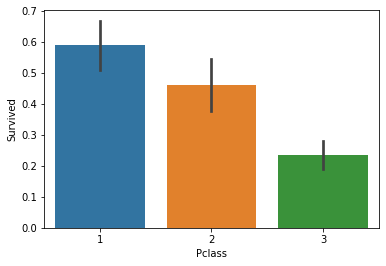

In [17]:
# Pclass 客舱等级
sns.barplot(x='Pclass', y='Survived', data=train)

(2)然后是性别和存活率的关系，我们可以看到女性的存活率远远高于男性

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

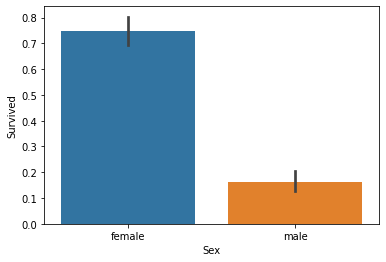

In [18]:
# Sex
sns.barplot(x='Sex', y='Survived', data=train)

(3)接着是年龄和存活率的关系，存活的人中会相对更年轻些

<AxesSubplot:xlabel='Survived', ylabel='Age'>

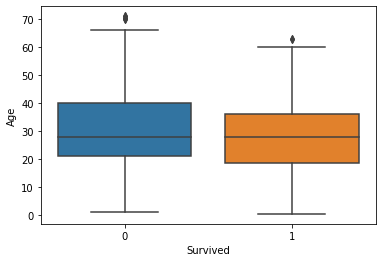

In [19]:
# Age 年龄
sns.boxplot(x='Survived', y='Age', data=train)

(4)然后是直系亲友数和存活率的关系，有直系亲友的存活率更高

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

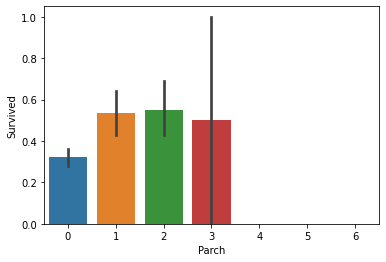

In [20]:
# Parch: 直系亲友数
sns.barplot(x='Parch', y='Survived', data=train)

(5)接着是旁系亲友数和存活率的关系，可以看到旁系亲友数过高反而不利于存活

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

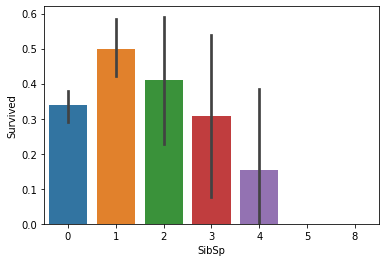

In [21]:
# SibSp: 旁系亲友数
sns.barplot(x='SibSp', y='Survived', data=train)

(6)然后是票编号共用数和存活率的关系，可以看到共用数2、3存活率较高

<AxesSubplot:xlabel='Ticket', ylabel='Survived'>

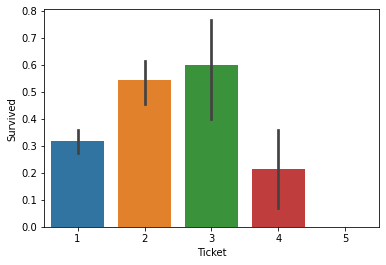

In [22]:
# Ticket: 票编号共用数
sns.barplot(x='Ticket', y='Survived', data=train)

(7)票价和存活率的关系，票价越高，存活率也越高

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

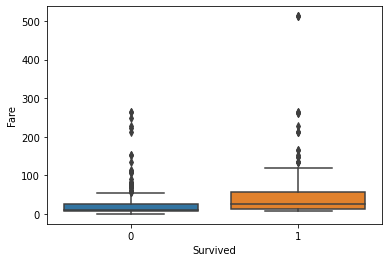

In [23]:
# Fare: 票价
sns.boxplot(x='Survived', y='Fare', data=train)

(8)船舱编号和存活率关系，可以看的A存活率最低，G存活率最高，其他差不多

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

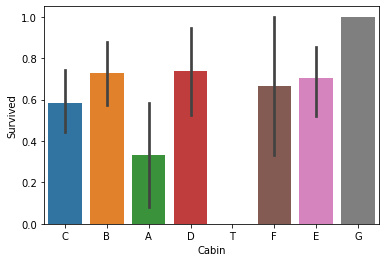

In [24]:
# Cabin: 船舱编号
sns.barplot(x='Cabin', y='Survived', data=train)

(9)上船的港口编号和存活率的关系，可以看的C港口存活率最高

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

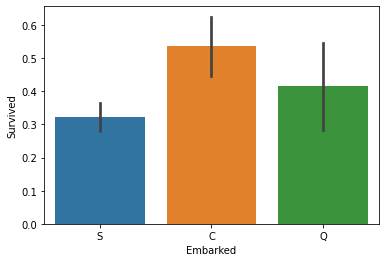

In [25]:
# Embarked: 上船的港口编号
sns.barplot(x='Embarked', y='Survived', data=train)

## 数据预处理

### 缺失值处理
&emsp; 这里我使用sklearn提供的缺失值转换器通过填补众数的方式来处理缺失值，之所以我还自定义了numpy对象到DataFrame对象转换器，是因为sklearn提供的处理器输出的都是ndarray对象，而DataFrame对象中特征信息在后面处理还需要用到，所以需要重新变回DataFrame对象

&emsp; 这里我使用了Pipeline管道这个概念，它可以把n个转换器[+ 评估器]连接起来～

In [26]:
features = X_train_.columns.values #提取输入特征

#自定义ndarray对象到DataFrame对象转换器
class NdarrayToDataframe(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.features)

#缺失值转换器(用众数填补缺失值)
missingProcessor = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='most_frequent')),
    ('ntod', NdarrayToDataframe(features))
])

#用缺失值转换器处理X_train
X_train_ = missingProcessor.fit_transform(X_train_)
print(X_train_.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


### 特征编码
因为标签变量的值为字符串类型，比如Sex变量的取值为"man"和"felman"，影响后面模型的训练，所以我们要对标签变量进行编码

In [27]:
class MyLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode
        self.labelEncoders = []
        for i in range(len(self.columns)):
            self.labelEncoders.append(LabelEncoder())
    def fit(self,X,y=None):
        for i in range(len(self.columns)):
            self.labelEncoders[i].fit(X[self.columns[i]])
        return self # not relevant here

    def transform(self,X, y=None):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        X = X.copy()
        for i in range(len(self.columns)):
            X[self.columns[i]] = self.labelEncoders[i].transform(X[self.columns[i]])
        return X

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
#特征划分
categorical_features = ['Sex', 'Cabin', 'Embarked'] #标签变量
encoderProcessor = MyLabelEncoder(categorical_features)
#对数据进行编码
X_train_ = encoderProcessor.fit_transform(X_train_)
X_train_.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,0,19,1,0,1,7.8542,2,2
1,2,1,19,0,0,1,13,2,2
2,2,1,52,0,0,2,13,2,2
3,3,1,17,1,1,1,7.2292,2,0
4,3,0,47,1,0,1,14.5,2,2


## 模型建立、选择、训练
&emsp; 模型使用sklearn上的估计器

&emsp; 估计器是sklearn提供的应一个强大的类，它封装了某个模型，比如决策树模型、贝叶斯模型等等，使用者可以不需要知道其内部具体细节，通过创建估计器对象创建模型，调用fit方法训练模型，调用predict或者predict_proba方法来预测结果。

### 决策树

In [28]:
# 模型建立
clf_tree = tree.DecisionTreeClassifier()
# 模型选择
  #超参数的取值范围
param_grid ={          
    'criterion': ['entropy', 'gini'],
    'max_depth':[2,3,4,5,6,7,8],
    'min_samples_split': [4, 8, 12, 16, 20,24, 28]
}
  #使用网格调参处理器来找到模型的最优超参数
'''
    参数：
      estimator 为处理的评估器
      param_grib为要处理的超参数以及取值范围
      scoring 为评估函数
      cv 为交叉验证折数
'''
gscv = GridSearchCV(estimator=clf_tree, param_grid=param_grid,
                   scoring='roc_auc', cv=4)
gscv.fit(X_train_, y_train)
print(gscv.best_params_, gscv.best_score_)

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 4} 0.871573939388951


In [29]:
'''
整合最终的树模型
因为下面的模型评估中需要对测试集做与训练集相同的特征处理、缺失值
处理编码处理、评估器训练，所以我将上面处理器的封装起来，再用管道将它们
封装起来，使其流水线化
'''
#特征转换器
featureProcessor = FeatureProcessor() 
#缺失值转换器
missingProcessor = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='most_frequent')),
    ('ntod', NdarrayToDataframe(features))
])
#编码转换器
encoderProcessor = MyLabelEncoder(categorical_features)
#最终的决策树估计器
clf_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth = 3,
                                      min_samples_split=4)
#形成流水线
pipeline_tree = Pipeline(steps=[
    ('featureProcessor', featureProcessor),
    ('missingProcessor', missingProcessor),
    ('encoderProcessor', encoderProcessor),
    ('clf_tree', clf_tree)
]) 

### 高斯贝叶斯分类器

In [30]:
# 模型建立
clf_bayes = GaussianNB()
#模型选择(因为该估计器没有超参数，所以就不需要模型选择)

In [31]:
'''
整合最终的贝叶斯模型
'''
#特征转换器
featureProcessor = FeatureProcessor() 
#缺失值转换器
missingProcessor = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='most_frequent')),
    ('ntod', NdarrayToDataframe(features))
]) 
#编码转换器
encoderProcessor = MyLabelEncoder(categorical_features)
#最终的贝叶斯估计器
clf_bayes = GaussianNB()
#形成流水线
pipeline_bayes = Pipeline(steps=[
    ('featureProcessor', featureProcessor),
    ('missingProcessor', missingProcessor),
    ('encoderProcessor', encoderProcessor),
    ('clf_bayes', clf_bayes)
]) 

## 模型评估
&emsp; 使用ROC曲线对模型进行评估——ROC曲线的AUC值越大，则模型越好

In [33]:
#训练两个模型并得到预测结果
pipeline_tree.fit(X_train, y_train)
y_test_proba_tree =pipeline_tree.predict_proba(X_test)

pipeline_bayes.fit(X_train, y_train)
y_test_proba_bayes = pipeline_bayes.predict_proba(X_test)

#取得两个模型的存活率预测结果
y_scores_tree = y_test_proba_tree[:, 1]
y_scores_bayes = y_test_proba_bayes[:, 1]

### 评估决策树模型

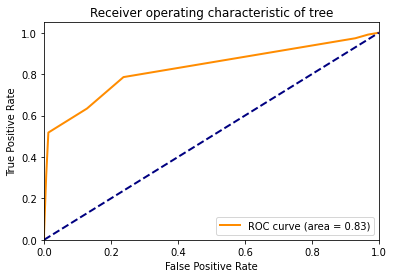

In [34]:
#计算真阳率、假阳率、auc值
fpr, tpr, thresholds = roc_curve(y_test, y_scores_tree, pos_label=1) 
auc_value = auc(fpr, tpr)
#绘制图像
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of tree')
plt.legend(loc="lower right")
plt.show()

### 评估贝叶斯模型

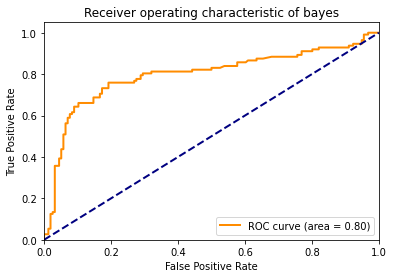

In [35]:
#评估bayes模型
#计算真阳率、假阳率、auc值
fpr, tpr, thresholds = roc_curve(y_test, y_scores_bayes, pos_label=1)
auc_value = auc(fpr, tpr)
#绘制图像
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of bayes')
plt.legend(loc="lower right")
plt.show()

可以从运行结果，可以看出，决策树模型优于高斯贝叶斯模型

## 模型可视化

In [36]:
#可视化决策树,图片保存于当前目录下的ouput/tree.png中
dot_data = tree.export_graphviz(
    pipeline_tree['clf_tree'], 
    out_file=None, 
    feature_names=features,
    max_depth=3,
    class_names=['0','1'],
    filled=True
) 
            
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 
f = open('output/tree.png', 'wb')
f.close()
with open('output/tree.png', 'wb') as f:
    f.write(graph.create_png())

![决策书可视化](output/tree.png)